In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
savedir = '32x32-mlp'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root
#print(np.array(hdf5['image_classes'])[0])
#raise
#label_index = np.array(hdf5['image_classes']).astype(int)

try:
    dataset = np.load('captures/fei/cache.npy')
    #dataset = np.load('captures/200807/glia_data.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class ResNet(torch.nn.Module):
    def __init__(self, filters=2048):
        super(ResNet, self).__init__()
        self.filters = filters
        
        self.w_in = torch.nn.Linear(10*6*32*32,self.filters, bias=False)
        self.w_out =  torch.nn.Linear(self.filters, 64*64, bias=True)
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::2,::2].contiguous()
        zx = F.relu(self.w_in(x.view(-1,10*6*32*32)))
        return torch.sigmoid(self.w_out(zx).view(-1,64,64))

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
batch_size = 20

model = ResNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 134221824 parameters
Initial Loss: 4.073973


In [9]:
batch_size = 20
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(50):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train.cpu().numpy()/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss.cpu().numpy()/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.677893	1.115321	3.441085	0.072340
1	0.914051	0.878114	3.432479	0.072183
2	0.712430	0.768305	3.431315	0.072126
3	0.586593	0.720731	3.431478	0.072311
4	0.501561	0.701641	3.432045	0.072310
5	0.444930	0.668839	3.431911	0.072276
6	0.402729	0.653676	3.431794	0.072353
7	0.363944	0.639915	3.431937	0.072263
8	0.332481	0.639497	3.430113	0.072123
9	0.296173	0.630675	3.429340	0.072102
10	0.265966	0.626139	3.430238	0.072138
11	0.240800	0.622713	3.430679	0.072245
12	0.223151	0.624223	3.429932	0.072109
13	0.204261	0.622362	3.429578	0.072022
14	0.185954	0.622864	3.428739	0.072193
15	0.177464	0.617173	3.429082	0.072288
16	0.159179	0.617099	3.428933	0.072291
17	0.142904	0.644181	3.429358	0.072129
18	0.132616	0.618431	3.429659	0.072376
19	0.125892	0.644691	3.429651	0.072141
20	0.119768	0.633096	3.428772	0.072247
21	0.113206	0.626827	3.429233	0.072325
22	0.112880	0.659010	3.429773	0.072315
23	0.115099	0.694894	3.429525	0.072529
24	0.107486	0.648232	3.428604	0.072

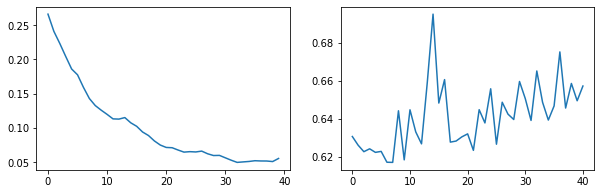

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [11]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 41.991882


In [15]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/originals')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        cv2.imwrite(f'final-outputs/originals/{prefix}-person{person}-pose{pose}.png', 255*targets[i].numpy())

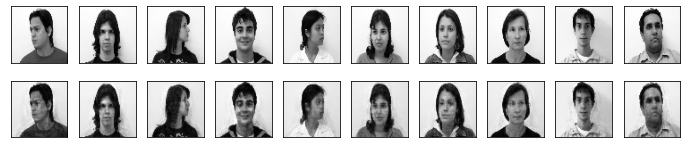

In [12]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

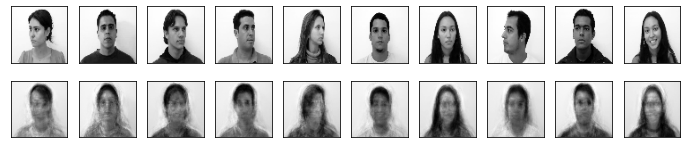

In [16]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])